In [1]:
import pandas as pd
import numpy as np
import math

In [ ]:
!pip install sklearn-ts==0.0.1

#Load data

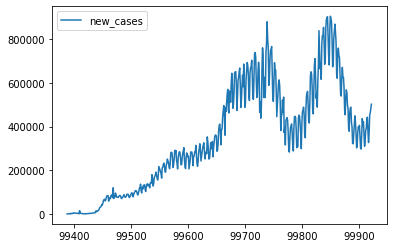

In [60]:
covid = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")
#covid.head(2)

target = 'new_cases'
h = 14

dataset = covid[(covid['location']=='World')].copy()[[target, 'date']]
dataset[[target]].plot()

In [61]:
# prepare features
features = ['year', 'month', f'{h}_lag', f'{h}_lag_rolling', 'dayofweek', 'intercept', 'trend', 'log']
categorical_features = ['year', 'month', 'dayofweek']
numerical_features = ['intercept', 'trend', 'log', f'{h}_lag_rolling']
lag_features= []

dataset['date'] = pd.to_datetime(dataset['date'])
dataset.index = dataset['date']
dataset['month'] = dataset['date'].dt.month
dataset['year'] = dataset['date'].dt.year
dataset['dayofweek'] = dataset['date'].dt.dayofweek

for lag in [h + i for i in range(14)]:
    dataset[f'{lag}_lag'] = dataset[target].shift(lag)
    lag_features.append(f'{lag}_lag')

dataset[f'rolling_{target}'] = dataset[target].rolling(window=h).mean()
dataset[f'{h}_lag_rolling'] = dataset[f'rolling_{target}'].shift(h)
dataset['intercept'] = 1
dataset['trend'] = range(dataset.shape[0])
dataset['log'] = dataset['trend'].apply(lambda x: math.log(x+1))
dataset = dataset[['date', target] + numerical_features + categorical_features + lag_features]
dataset = dataset.dropna()

# Fourier

# Hierarchical

In [5]:
covid.head(2)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
0,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,0.026,0.026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN


In [23]:
continents = covid['continent'].dropna().unique()

In [16]:
dataset = covid[(covid['location']=='World') | (covid['location'].isin(continents))].copy()[['location', target, 'date']]
dataset['date'] = pd.to_datetime(dataset['date'])
#dataset.index = dataset['date']

In [17]:
dataset.head()

,location,new_cases,date
502,Africa,0.0,2020-02-13
503,Africa,1.0,2020-02-14
504,Africa,0.0,2020-02-15
505,Africa,0.0,2020-02-16
506,Africa,0.0,2020-02-17


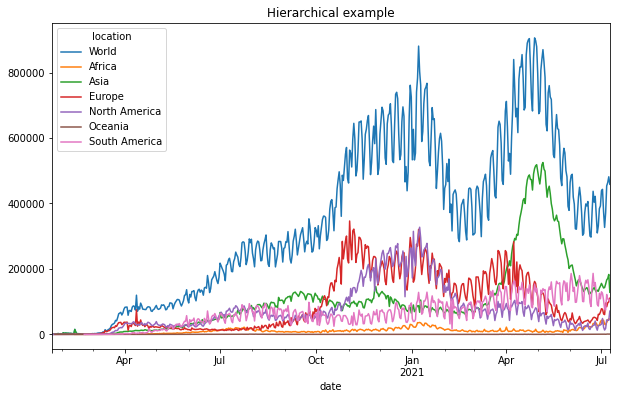

In [32]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
pivoted = pd.pivot_table(dataset, values='new_cases', index='date', columns='location', aggfunc='sum')[['World'] + sorted(list(continents))]
pivoted.plot(title='Hierarchical example', ax=axes)
fig.savefig(f'continents.png')

In [33]:
!pip install scikit-hts

     |████████████████████████████████| 81kB 9.4MB/s 
     |████████████████████████████████| 9.5MB 30.0MB/s 
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [34]:
import hts

In [38]:
pivoted.head()

location,total,Africa,Asia,Europe,North America,Oceania,South America
date,,,,,,,
2020-01-22,0.0,NaN,0.0,NaN,0.0,NaN,NaN
2020-01-23,98.0,NaN,98.0,0.0,0.0,NaN,NaN
2020-01-24,286.0,NaN,283.0,2.0,1.0,NaN,NaN
2020-01-25,492.0,NaN,491.0,1.0,0.0,0.0,NaN
2020-01-26,685.0,NaN,677.0,0.0,4.0,4.0,NaN


In [46]:
hierarchy = {'total': list(continents)}
pivoted = pivoted.rename(columns={'World': 'total'})

model_bu_arima = hts.HTSRegressor(model='prophet', revision_method='OLS', n_jobs=0)
model_bu_arima = model_bu_arima.fit(pivoted, hierarchy)




Fitting models:   0%|          | 0/7 [00:00<?, ?it/s]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Fitting models:  14%|█▍        | 1/7 [00:00<00:01,  5.79it/s]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Fitting models:  29%|██▊       | 2/7 [00:00<00:00,  6.25it/s]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Fitting models:  43%|████▎     | 3/7 [00:00<00:00,  5.30it/s]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily




Fitting models:   0%|          | 0/7 [00:00<?, ?it/s]


Fitting models:  14%|█▍        | 1/7 [00:01<00:11,  1.83s/it]


Fitting models:  29%|██▊       | 2/7 [00:03<00:09,  1.84s/it]


Fitting models:  43%|████▎     | 3/7 [00:05<00:07,  1.87s/it]


Fitting models:  57%|█████▋    | 4/7 [00:07<00:05,  1.87s/it]


Fitting models:  71%|███████▏  | 5/7 [00:09<00:03,  1.86s/it]


Fitting models:  86%|████████▌ | 6/7 [00:11<00:01,  1.84s/it]


Fitting models: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x7f5eff902f90>


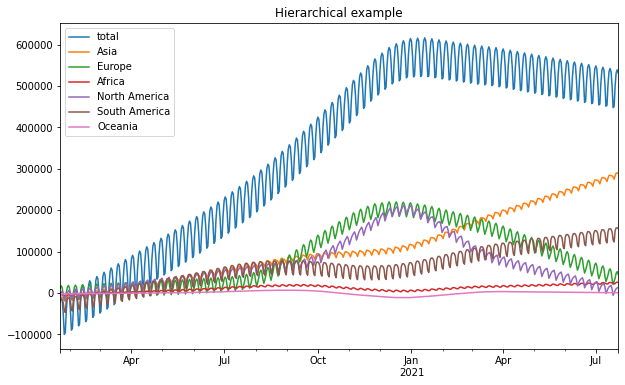

In [47]:
pred_bu_arima = model_bu_arima.predict(steps_ahead=14)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
pred_bu_arima.plot(title='Hierarchical example', ax=axes)
fig.savefig(f'continents_predicted.png')

# Power transform

## Box-Cox

In [64]:
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression

In [80]:
pt = PowerTransformer(method='box-cox')
dataset['box-cox'] = np.squeeze(pt.fit_transform(dataset[['new_cases']]+1))
pt.lambdas_

array([0.59842567])

In [104]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer(
    transformers=[('num', FunctionTransformer(), numerical_features)]
)

pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', LinearRegression())])

tt = TransformedTargetRegressor(regressor=pipeline, transformer=PowerTransformer(method='box-cox'))
tt.fit(dataset[numerical_features], dataset[target])

TransformedTargetRegressor(check_inverse=True, func=None, inverse_func=None,
                           regressor=Pipeline(memory=None,
                                              steps=[('preprocessor',
                                                      ColumnTransformer(n_jobs=None,
                                                                        remainder='drop',
                                                                        sparse_threshold=0.3,
                                                                        transformer_weights=None,
                                                                        transformers=[('num',
                                                                                       FunctionTransformer(accept_sparse=False,
                                                                                                           check_inverse=True,
                                                                              

In [105]:
dataset['pred'] = tt.predict(dataset[numerical_features])

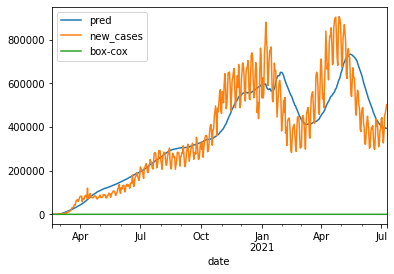

In [106]:
dataset[['pred', 'new_cases', 'box-cox']].plot()

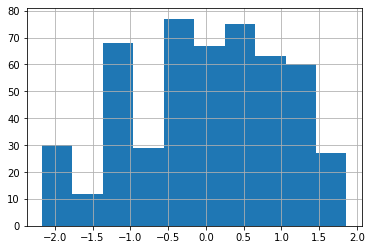

In [107]:
dataset['box-cox'].hist()

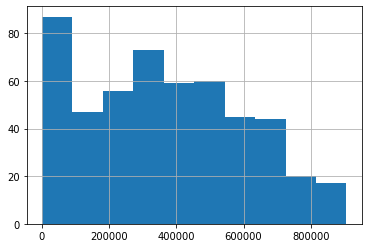

In [108]:
dataset['new_cases'].hist()

In [109]:
tt.regressor.named_steps['regressor']

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [110]:
tt.transformer.lambdas_

AttributeError: ignored